# Linear Classification
George Ho 10/19/17

The aim of this project is to demonstrate two common methods of linear classification: a probabilistic generative model and logistic regression. This project was rushed, and there are several things that can be done to improve them:

- Plot a ROC curve for both of your classifiers

- Plot the decision boundary for both your classifiers (it should be a line)

- Go to Kaggle or the UCI machine learning database, find a dataset that interests you, and try your classifiers on it. Make sure it is a binary dataset with only numerical features.

- Implement IRLS with the lasso penalty

In [1]:
import numpy as np

In [2]:
# Ground truth
pi = 0.4
mu1 = np.ones(2)
mu2 = -np.ones(2)
sigma = np.identity(2)

In [3]:
# Training data
train_class1 = np.random.multivariate_normal(mu1, sigma, round(500*pi))
train_class2 = np.random.multivariate_normal(mu2, sigma, round(500*(1-pi)))

train_binary_data = np.vstack([train_class1, train_class2])
train_class_label = np.hstack([np.ones(round(500*pi)), np.zeros(round(500*(1-pi)))])

In [4]:
# Test data
test_class1 = np.random.multivariate_normal(mu1, sigma, round(100*pi))
test_class2 = np.random.multivariate_normal(mu2, sigma, round(100*(1-pi)))

test_binary_data = np.vstack([test_class1, test_class2])
test_class_labels = np.hstack([np.ones(round(100*pi)), np.zeros(round(100*(1-pi)))])

## Generative Model: Gaussian Class-Conditional Probabilities

In [5]:
# ML estimation of pi, mu1, mu2

pi_est = np.count_nonzero(train_class_label)/train_class_label.size
mu1_est = train_binary_data[train_class_label == 1].mean(axis=0)
mu2_est = train_binary_data[train_class_label == 0].mean(axis=0)

In [6]:
# There is probably a better way of doing this... but idk

# Computing S1
vectors1 = train_binary_data[train_class_label == 1] - mu1_est
foo = np.zeros([len(vectors1), 2, 2])
for i, row in enumerate(vectors1):
    foo[i] = np.outer(row, row)
S1 = foo.mean(axis=0)

# Computing S2
vectors2 = train_binary_data[train_class_label == 0] - mu2_est
bar = np.zeros([len(vectors2), 2, 2])
for i, row in enumerate(vectors2):
    bar[i] = np.outer(row, row)
S2 = bar.mean(axis=0)

In [7]:
# ML estimation of sigma

N1 = train_binary_data[train_class_label == 1].size
N2 = train_binary_data[train_class_label == 0].size
sigma_est = (N1/(N1+N2))*S1 + (N2/(N1+N2))*S2

In [8]:
w = np.linalg.inv(sigma_est) @ (mu1_est-mu2_est)
w_0 = - 0.5*(mu1_est.T @ np.linalg.inv(sigma_est) @ mu1_est) \
      + 0.5*(mu2_est.T @ np.linalg.inv(sigma_est) @ mu2_est) \
      + np.log(pi_est / (1-pi_est))

In [9]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def posterior_probability(x):
    return sigmoid(w@x + w_0)

In [10]:
class_decisions = list(map(lambda x: 1 if posterior_probability(x) > 0.5 else 0, test_binary_data))

success = class_decisions == test_class_labels
misclassification_rate = (success.size - np.count_nonzero(success)) / 100

In [11]:
misclassification_rate

0.04

## Discriminative Model: Iteratively Reweighted Logistic Regression

_Without_ nonlinear basis functions... Just by graphing the training data, it looks like they're pretty linearly separable.

In [12]:
# Initial guess
w = np.atleast_2d(np.ones([3,1]))

In [13]:
# Logistic regression
phi = np.ones([500, 3])
phi[:, 1:] = train_binary_data
t = train_class_label.reshape(500, 1)

for _ in range(100):
    y = sigmoid((w.T*phi).sum(axis=1)).reshape([500,1])
    R = np.diag(np.multiply(y, 1-y).flatten())
    z = phi @ w - np.linalg.inv(R) @ (y - t)
    w = np.linalg.inv(phi.T @ R @ phi) @ phi.T @ R @ z

In [14]:
def posterior_probability(x):
    return sigmoid(np.multiply(w.T, x).sum(axis=1))

In [15]:
test_phi = np.ones([100, 3])
test_phi[:, 1:] = test_binary_data

In [17]:
class_decisions = list(map(lambda x: 1 if posterior_probability(x) > 0.5 else 0, test_phi))

success = class_decisions == test_class_labels
misclassification_rate = (success.size - np.count_nonzero(success)) / 100

In [18]:
misclassification_rate

0.04

## Iteratively Reweighted Least Squares with Non-Linear Basis Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

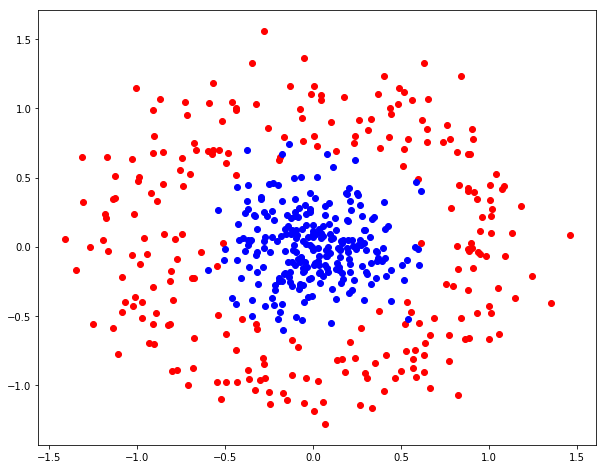

In [2]:
X, t = make_circles(n_samples=500, noise=0.2, factor=0.2)

reds = (t == 0)
blues = (t == 1)

fig, ax = plt.subplots(figsize=[10, 8])
ax.scatter(X[reds, 0], X[reds, 1], c="r")
ax.scatter(X[blues, 0], X[blues, 1], c="b")
plt.show()

In [3]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [12]:
# Gaussian radial basis function
# Centered at [0, 0] and [-2, -2], scale factor 

phi1 = np.exp(np.linalg.norm(X - [0, 0], axis=1)**2 / 20)
phi2 = np.exp(np.linalg.norm(X - [-2, -2], axis=1)**2 / 20)

phi = np.ones([500, 3])
phi[:, 1] = phi1
phi[:, 2] = phi2

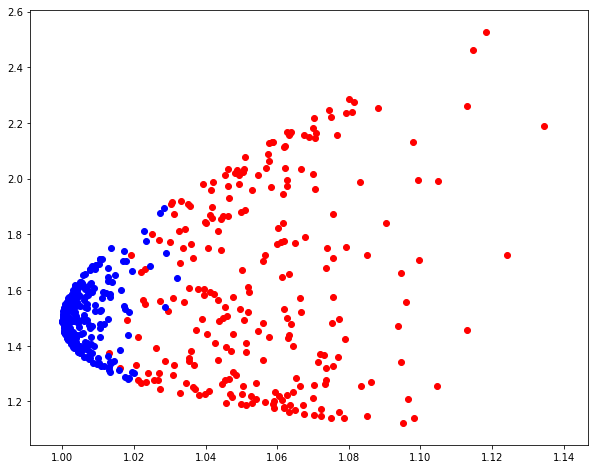

In [5]:
fig, ax = plt.subplots(figsize=[10, 8])
ax.scatter(phi[reds, 1], phi[reds, 2], c="r")
ax.scatter(phi[blues, 1], phi[blues, 2], c="b")
plt.show()

In [14]:
# Initial guess
w = np.atleast_2d(np.ones([3,1]))

In [15]:
# Logistic regression
t = t.reshape(500, 1)

for _ in range(1):
    y = sigmoid((w.T*phi).sum(axis=1)).reshape([500,1])
    R = np.diag(np.multiply(y, 1-y).flatten())
    z = phi @ w - np.linalg.inv(R) @ (y - t)
    w = np.linalg.inv(phi.T @ R @ phi) @ phi.T @ R @ z

In [16]:
test_X, test_t = make_circles(n_samples=100, noise=0.2, factor=0.2)

In [17]:
# Gaussian radial basis function
# Centered at [0, 0] and [-2, -2], scale factor sqrt10

phi1 = np.exp(np.linalg.norm(test_X - [0, 0], axis=1)**2 / 20)
phi2 = np.exp(np.linalg.norm(test_X - [-1.5, -1.5], axis=1)**2 / 20)

test_phi = np.ones([100, 3])
test_phi[:, 1] = phi1
test_phi[:, 2] = phi2

In [18]:
def posterior_probability(x):
    return sigmoid(np.multiply(w.T, x).sum(axis=1))

In [19]:
class_decisions = list(map(lambda x: 1 if posterior_probability(x) > 0.5 else 0, test_phi))

success = class_decisions == test_t
misclassification_rate = (success.size - np.count_nonzero(success)) / 100

In [20]:
misclassification_rate

0.06

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

X, t = make_circles(n_samples=500, noise=0.2, factor=0.2)

reds = (t == 0)
blues = (t == 1)

fig, ax = plt.subplots(figsize=[10, 8])
ax.scatter(X[reds, 0], X[reds, 1], c="r")
ax.scatter(X[blues, 0], X[blues, 1], c="b")
plt.show()

## Discriminative Model: Iteratively Reweighted Logistic Regression

def sigmoid(z):
    return 1/(1+np.exp(-z))

# Gaussian radial basis function
# Centered at [0, 0] and [-2, -2], scale factor 

phi1 = np.exp(np.linalg.norm(X - [0, 0], axis=1)**2 / 20)
phi2 = np.exp(np.linalg.norm(X - [-2, -2], axis=1)**2 / 20)

phi = np.ones([500, 3])
phi[:, 1] = phi1
phi[:, 2] = phi2

fig, ax = plt.subplots(figsize=[10, 8])
ax.scatter(phi[reds, 1], phi[reds, 2], c="r")
ax.scatter(phi[blues, 1], phi[blues, 2], c="b")
plt.show()

# Initial guess
w = np.atleast_2d(np.ones([3,1]))

# Logistic regression
t = t.reshape(500, 1)

for _ in range(1):
    y = sigmoid((w.T*phi).sum(axis=1)).reshape([500,1])
    R = np.diag(np.multiply(y, 1-y).flatten())
    z = phi @ w - np.linalg.inv(R) @ (y - t)
    w = np.linalg.inv(phi.T @ R @ phi) @ phi.T @ R @ z

test_X, test_t = make_circles(n_samples=100, noise=0.2, factor=0.2)

# Gaussian radial basis function
# Centered at [0, 0] and [-2, -2], scale factor sqrt10

phi1 = np.exp(np.linalg.norm(test_X - [0, 0], axis=1)**2 / 20)
phi2 = np.exp(np.linalg.norm(test_X - [-1.5, -1.5], axis=1)**2 / 20)

test_phi = np.ones([100, 3])
test_phi[:, 1] = phi1
test_phi[:, 2] = phi2

def posterior_probability(x):
    return sigmoid(np.multiply(w.T, x).sum(axis=1))

class_decisions = list(map(lambda x: 1 if posterior_probability(x) > 0.5 else 0, test_phi))

success = class_decisions == test_t
misclassification_rate = (success.size - np.count_nonzero(success)) / 100

misclassification_rate